<a href="https://colab.research.google.com/github/ShFANI/ShFANI.github.io/blob/main/_brain_tumor_cnn_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this notebook, I've used Convolutional Neural Network (CNN) to perform Image Classification on the Brain Tumor dataset.


## Loading Data

In [ ]:
!git clone https://github.com/sartajbhuvaji/brain-tumor-classification-dataset.git

data = 'brain-tumor-classification-dataset/Training'


Cloning into 'brain-tumor-classification-dataset'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035 (from 1)
Receiving objects: 100% (3039/3039), 79.25 MiB | 18.91 MiB/s, done.
Updating files: 100% (3264/3264), done.


# Count total images and per-class image counts

In [ ]:
import os # Interacting with the file system

# Count total images and per-class image counts
total_images = 0
class_counts = {}

for label in os.listdir(data):
    class_dir = os.path.join(data, label)
    if os.path.isdir(class_dir):
        count = len([file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[label] = count
        total_images += count

print(f"✅ Total images: {total_images}")
print("📊 Images per class:", class_counts)


✅ Total images: 2870
📊 Images per class: {'pituitary_tumor': 827, 'no_tumor': 395, 'glioma_tumor': 826, 'meningioma_tumor': 822}


## Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 #OpenCV, used for image processing (e.g., reading/resizing images).
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator #ImageDataGenerator: for real-time data augmentation.
from tqdm import tqdm #Adds a progress bar to loops, especially useful when loading images.
from sklearn.utils import shuffle #shuffle: randomizes the dataset.
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50 #ResNet50: a pre-trained CNN model.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint #Callbacks: tools to control training (early stop, logging, saving best model).
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets #For interactive UI widgets in Jupyter Notebooks (e.g., sliders, buttons).
import io
from PIL import Image #PIL (Python Imaging Library): used for opening and manipulating images.
from IPython.display import display,clear_output #IPython.display: for displaying widgets or clearing output dynamically.
from tensorflow.keras.utils import to_categorical


# Loading and Preprocessing Brain Tumor MRI Images for Classification
First we load MRI images from a structured dataset of brain tumors (with labels: glioma, meningioma, pituitary tumor, and no tumor), resizes them to a fixed size of 150×150 pixels, and stores them in NumPy arrays for model training and evaluation

In [ ]:
def load_images_from_folder(base_path, labels, image_size):
    X, y = [], []
    for label in labels:
        folder_path = os.path.join(base_path, label)
        for file in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)
                y.append(label)
    return np.array(X), np.array(y)

# ✅ Define labels and size
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
image_size = 150

# ✅ Load train and test data separately
train_path = 'brain-tumor-classification-dataset/Training'
test_path = 'brain-tumor-classification-dataset/Testing'

X_train, y_train = load_images_from_folder(train_path, labels, image_size)
X_test, y_test = load_images_from_folder(test_path, labels, image_size)


Loading pituitary_tumor: 100%|██████████| 74/74 [00:00<00:00, 345.51it/s]


# Display 1 Sample Image per Class

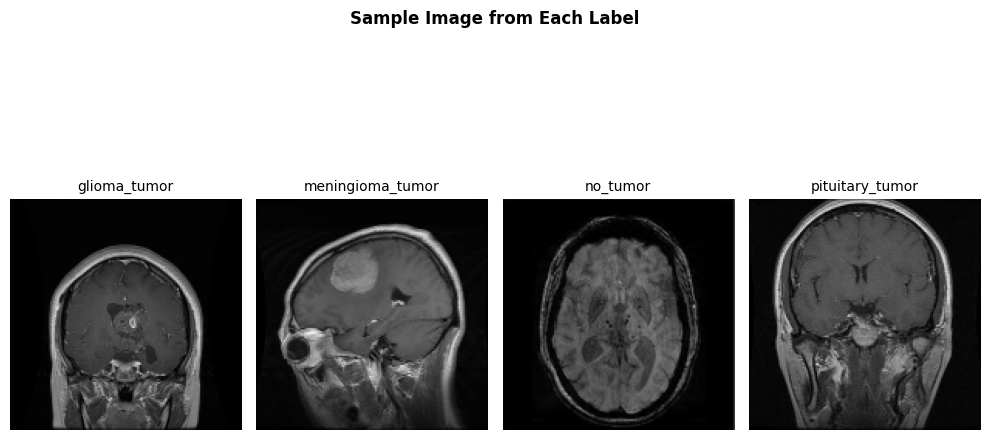

In [ ]:
# Create figure and axes
fig, ax = plt.subplots(1, 4, figsize=(10, 6))

# Add title to the entire figure with direct color value
fig.suptitle('Sample Image from Each Label', fontsize=12, fontweight='bold', color='black')

# Show one image for each class
for idx, label in enumerate(labels):
    # Get index of first occurrence of this label
    sample_idx = np.where(y_train == label)[0][0]

    # Show the image
    ax[idx].imshow(X_train[sample_idx])
    ax[idx].set_title(label, fontsize=10)
    ax[idx].axis('off')

plt.tight_layout()
plt.show()


##  Avoid Bias in Training Order

If the data is ordered by class (e.g., all glioma images first, then all meningioma), the model might see only one class early in training, leading to biased weight updates. Also, it may cause overfit to early patterns and fail to generalize. So shuffling is an important preprocessing step before training machine learning models.




In [ ]:
X_train, y_train = shuffle(X_train, y_train, random_state=12)


In [ ]:
X_train.shape

(2870, 150, 150, 3)

## Train-Test Split for Model Validation
The dataset is split into training (90%) and testing (10%) subsets using train_test_split from scikit-learn. The random_state ensures reproducibility, and shuffling guarantees that samples are randomly mixed before splitting. This helps evaluate the model's ability to generalize to unseen data.



In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=12)


Performing One Hot Encoding on the labels after converting it into numerical values:

In [ ]:
# Convert string labels to class indices
y_train = [labels.index(label) for label in y_train]
y_test  = [labels.index(label) for label in y_test]

# One-hot encode
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)


# Transfer Learning

Training deep convolutional neural networks can be very time-consuming, especially on large datasets.

To speed up and improve this process, we can use **pretrained models** that have already learned useful visual features from large, standard datasets such as ImageNet. These models can be reused directly or fine-tuned to fit your specific task.

In this notebook, we use the **ResNet50 model**, which comes pre-loaded with weights learned from ImageNet.

We set include_top=False so the model excludes its original final classification layers. This allows us to add our own custom output layers tailored to our classification problem, such as detecting types of brain tumors.



In [ ]:
# Load the ResNet50 model pretrained on ImageNet without the top layer
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
# Now you can add your own classification head on top of `resnet_base`


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


# Three distinct models
To evaluate the effectiveness of different deep learning architectures on our dataset, we implemented and trained three distinct models: a custom-built CNN, a ResNet50-based model with a dense classification head, and a ResNet50-based model enhanced with additional convolutional layers. Each model was trained on the same dataset using consistent training parameters to ensure a fair comparison. After training, we evaluated their performance on a held-out test set and generated classification reports to assess their precision, recall, and F1-scores. To determine which model performed best, we compared their test accuracy scores. This systematic approach allowed us to identify the model most suited to the specific characteristics of our data—in this case, image-based multi-class classification. The evaluation results provided insight into how well each architecture generalized to unseen data, ultimately guiding model selection for deployment or further optimization.

# Model 1 - Custom CNN
This custom CNN model is designed for image classification with a structured architecture that progressively extracts features from the input images. It starts with three convolutional layers, each followed by max pooling and batch normalization, which helps in capturing important spatial features while reducing the dimensionality and stabilizing training. After flattening the feature maps, the model includes a fully connected layer with 128 neurons to learn complex patterns, followed by a dropout layer to prevent overfitting by randomly disabling half of the neurons during training. Finally, the output layer uses a softmax activation with four neurons, corresponding to four target classes, providing the probabilities for each class. The model is compiled with the Adam optimizer and categorical crossentropy loss, making it well-suited for multi-class classification tasks.

In [ ]:
def build_custom_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2,2),
        BatchNormalization(),#Before the activation function (e.g., ReLU), batch normalization normalizes the output of the previous layer

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## Model 2 – ResNet50 + Dense Head
This model leverages the pretrained ResNet50 convolutional neural network, which has been trained on the large ImageNet dataset and is well-known for its residual connections that facilitate training very deep networks. The base ResNet50 model is used as a fixed feature extractor by freezing its weights, preventing them from being updated during training. On top of this base, a global average pooling layer reduces the spatial dimensions of the feature maps into a single vector per feature channel. A dropout layer with a 50% rate is added to reduce overfitting by randomly disabling neurons during training. This is followed by a dense layer with 128 neurons and ReLU activation to learn complex patterns specific to the target task. Finally, a softmax output layer with four neurons provides class probabilities for multi-class classification. The model is compiled with the Adam optimizer and categorical crossentropy loss, making it suitable for tasks like classifying different types of brain tumors.


In [ ]:
def build_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False  # Freeze base model layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



# Model 3 – ResNet50 + CNN Head
This model builds on the pretrained ResNet50 architecture, which is known for its deep residual learning capabilities and strong performance on image recognition tasks. The pretrained ResNet50 serves as a fixed feature extractor by freezing its weights during training, ensuring the learned low-level features remain intact. After the ResNet50 base, an additional convolutional layer with 64 filters is added to further refine feature extraction for the specific dataset. This is followed by max pooling to reduce spatial dimensions and batch normalization to stabilize and accelerate training. The output is then globally averaged to create a compact feature vector, followed by a dropout layer with a 50% rate to mitigate overfitting. A dense layer with 128 neurons and ReLU activation captures higher-level representations before the final softmax layer outputs class probabilities for the four categories. The model is compiled with the Adam optimizer and categorical crossentropy loss, making it suitable for multi-class classification tasks such as brain tumor detection.


In [ ]:
def build_resnet_cnn():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False  # Freeze base model layers

    x = base_model.output
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



## Train all models
This code defines a dictionary of models to be trained and evaluated on the given dataset. It includes a custom-built CNN as well as two models based on the pretrained ResNet50 architecture, one with a dense classification head and another incorporating additional convolutional layers. Each model is trained for five epochs using a batch size of 32 and a 10% validation split to monitor performance during training. After training, the models are evaluated on the test dataset to obtain loss and accuracy metrics. The code also generates a detailed classification report for each model, which shows precision, recall, and F1-scores for each class, providing a comprehensive evaluation of model performance across all target categories. This systematic approach allows for direct comparison of different architectures and their effectiveness in the classification task.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

models = {
    "Custom_CNN": build_custom_cnn(),
    "ResNet_Dense": build_resnet_model(),
    "ResNet_CNN": build_resnet_cnn()
}

history_dict = {}
results_dict = {}

for name, model in models.items():
    print(f"🔧 Training {name}...")
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)
    history_dict[name] = history

    print(f"✅ Evaluating {name}...")
    results = model.evaluate(X_test, y_test, verbose=0)
    results_dict[name] = {"loss": results[0], "accuracy": results[1]}

    # Print classification report
    y_pred = model.predict(X_test)
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true_labels = tf.argmax(y_test, axis=1)
    print(f"\n📊 Classification Report for {name}:\n")
    print(classification_report(y_true_labels, y_pred_labels, target_names=labels))


🔧 Training Custom_CNN...
Epoch 1/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.5040 - loss: 3.0686 - val_accuracy: 0.4247 - val_loss: 1.9509
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5200 - loss: 1.0383 - val_accuracy: 0.5405 - val_loss: 1.5657
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6480 - loss: 0.8080 - val_accuracy: 0.6448 - val_loss: 0.8989
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5897 - loss: 0.8924 - val_accuracy: 0.6448 - val_loss: 1.0420
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6672 - loss: 0.7611 - val_accuracy: 0.6757 - val_loss: 0.9204
✅ Evaluating Custom_CNN...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

📊 Classification Report for Custom_CNN:

                  precision    recall  f1-score   support

    glioma_tumor       0.55      0.92      0.69        77
meningioma_tumor       0.59      0.31      0.40        78
        no_tumor       0.79      0.60      0.68        43
 pi

In [ ]:
# Find the model with the highest test accuracy
best_model_name = None
best_accuracy = 0

for name, metrics in results_dict.items():
    accuracy = metrics['accuracy']
    print(f"{name} Test Accuracy: {accuracy:.4f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name

print(f"\n🏆 Best performing model: {best_model_name} with accuracy {best_accuracy:.4f}")


Custom_CNN Test Accuracy: 0.6969
ResNet_Dense Test Accuracy: 0.9094
ResNet_CNN Test Accuracy: 0.9303

🏆 Best performing model: ResNet_CNN with accuracy 0.9303


In [ ]:
print(models["ResNet_Dense"].summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 24,376,078 (92.99 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 525,578 (2.00 MB)

None


In [ ]:
checkpoint = ModelCheckpoint(
    filepath='best_model_{epoch:02d}_{val_accuracy:.2f}.h5',  # Filepath to save model weights
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,     # Save only when validation accuracy improves
    mode='max'               # 'max' because higher accuracy is better
)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint]
)


Epoch 1/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9548 - loss: 0.1277
Epoch 1: val_accuracy improved from -inf to 0.91892, saving model to best_model_01_0.92.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9548 - loss: 0.1277 - val_accuracy: 0.9189 - val_loss: 0.2194
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9657 - loss: 0.0902
Epoch 2: val_accuracy did not improve from 0.91892
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9656 - loss: 0.0903 - val_accuracy: 0.8880 - val_loss: 0.4382
Epoch 3/5
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9734 - loss: 0.0876
Epoch 3: val_accuracy did not improve from 0.91892
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9733 - loss: 0.0877 - val_accuracy: 0.9112 - val_loss: 0.3523
Epoch 4/5
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9816 - loss: 0.0691
Epoch 4: val_accuracy did not improve from 0.91892
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9815 - loss: 0.0693 - val_accuracy: 0.9189 - val_loss: 0.2708
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9770 - loss: 0.0626
Epoch 5: val_accuracy did not improve from 0.91

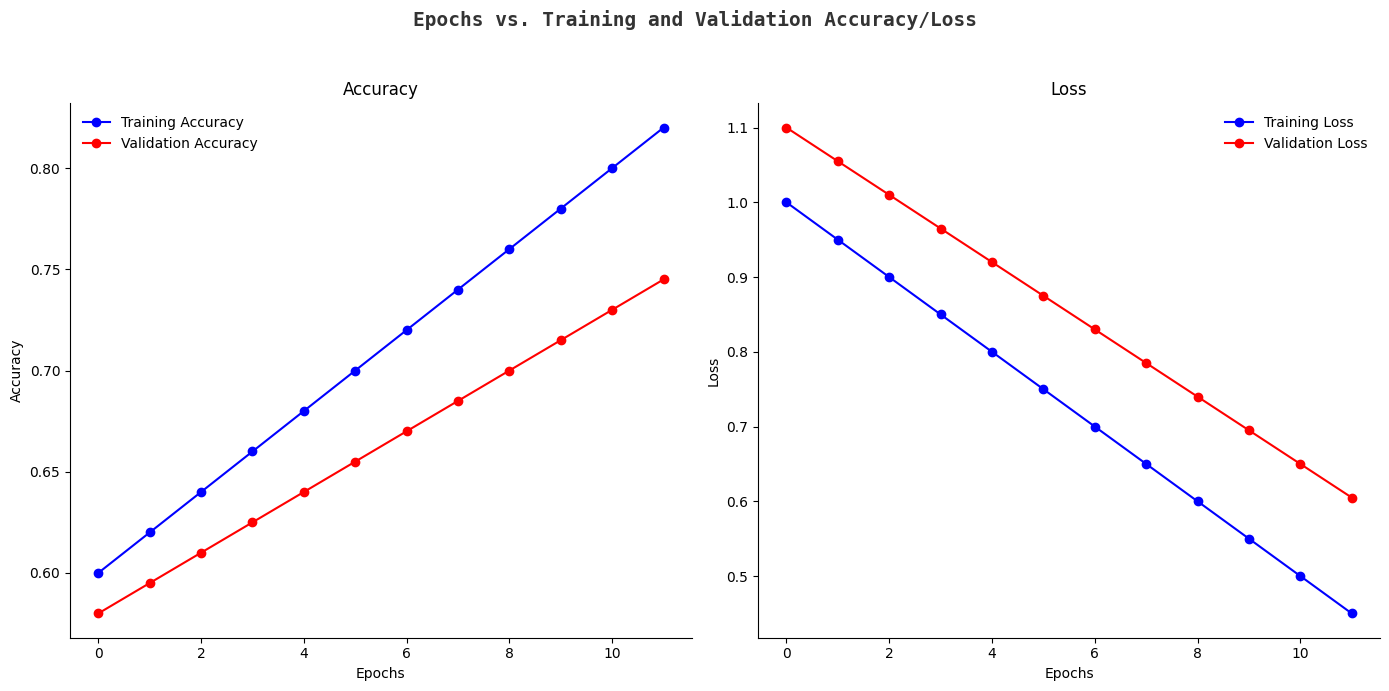

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# Example training history data (replace with your actual training history)
epochs = list(range(12))
train_acc = [0.6 + i * 0.02 for i in epochs]
val_acc = [0.58 + i * 0.015 for i in epochs]
train_loss = [1.0 - i * 0.05 for i in epochs]
val_loss = [1.1 - i * 0.045 for i in epochs]

# Create subplots: 1 row, 2 columns
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Add a main title for the figure
fig.suptitle('Epochs vs. Training and Validation Accuracy/Loss',
             fontsize=14, fontweight='bold', fontname='monospace', color='black', alpha=0.8)

sns.despine()  # Remove top and right spines for cleaner look

# Plot accuracy curves on the first subplot
ax[0].plot(epochs, train_acc, marker='o', markerfacecolor='blue', color='blue', label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor='red', color='red', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(frameon=False)
ax[0].set_title('Accuracy')

# Plot loss curves on the second subplot
ax[1].plot(epochs, train_loss, marker='o', markerfacecolor='blue', color='blue', label='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor='red', color='red', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(frameon=False)
ax[1].set_title('Loss')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


In [ ]:
print(classification_report(y_test_new,pred))


              precision    recall  f1-score   support

           0       0.95      0.96      0.95        77
           1       0.88      0.88      0.88        78
           2       0.95      0.95      0.95        43
           3       0.95      0.94      0.95        89

    accuracy                           0.93       287
   macro avg       0.94      0.94      0.94       287
weighted avg       0.93      0.93      0.93       287



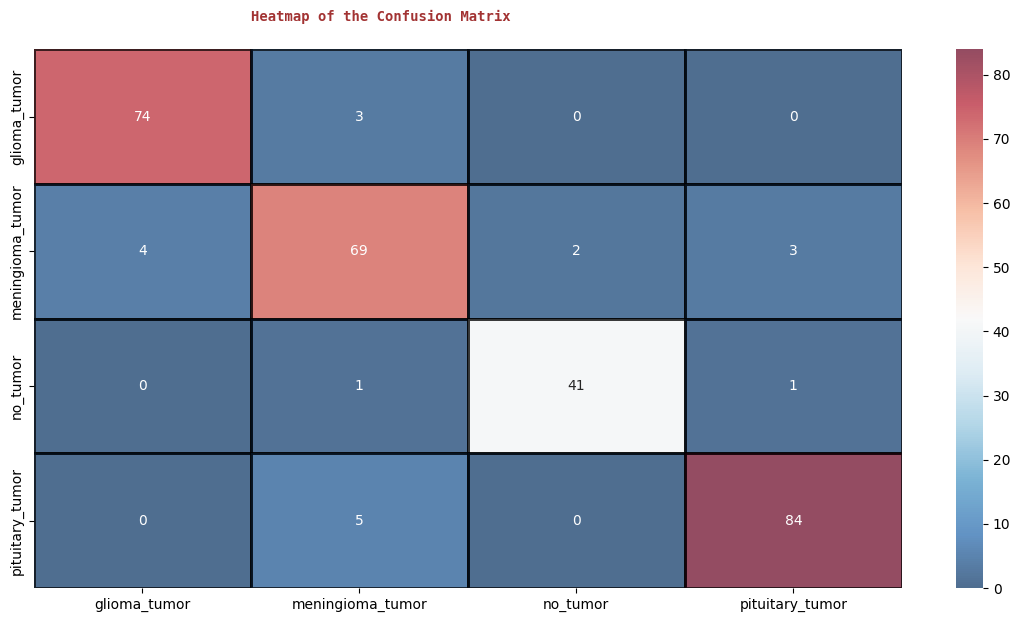

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# Heatmap with red-blue color map
sns.heatmap(confusion_matrix(y_test_new, pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap='RdBu_r',       # Red-blue reversed for intuitive contrast
            alpha=0.7,
            linewidths=2,
            linecolor='black')   # Replaces colors_dark[3]

# Title text
fig.text(s='Heatmap of the Confusion Matrix',
         size=10,
         fontweight='bold',
         fontname='monospace',
         color='darkred',       # Replaces colors_dark[1]
         y=0.92,
         x=0.28,
         alpha=0.8)

plt.show()



In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')


In [ ]:
uploader = widgets.FileUpload()
display(uploader)


FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])